In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

# !pip install --quiet shap==0.39.0
import shap

%matplotlib inline

sns.set_style('darkgrid')
pd. set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [5]:
#Importing data
df = pd.read_csv("E:\\Project\\RTA Dataset.csv")

EXploratory data analysis

In [6]:
df.shape

(12316, 32)

In [6]:
df.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [7]:
# renaming columns
col_map={
    'Time': 'time',
    'Day_of_week': 'day_of_week',
    'Age_band_of_driver': 'driver_age',
    'Sex_of_driver': 'driver_sex',
    'Educational_level': 'educational_level',
    'Vehicle_driver_relation': 'vehicle_driver_relation',
    'Driving_experience': 'driving_experience',
    'Type_of_vehicle': 'vehicle_type',
    'Owner_of_vehicle': 'vehicle_owner',
    'Service_year_of_vehicle': 'service_year',
    'Defect_of_vehicle': 'vehicle_defect',
    'Area_accident_occured': 'accident_area',
    'Lanes_or_Medians': 'lanes',
    'Road_allignment': 'road_allignment',
    'Types_of_Junction': 'junction_type',
    'Road_surface_type': 'surface_type',
    'Road_surface_conditions': 'road_surface_conditions',
    'Light_conditions': 'light_condition',
    'Weather_conditions': 'weather_condition',
    'Type_of_collision': 'collision_type',
    'Number_of_vehicles_involved': 'vehicles_involved',
    'Number_of_casualties': 'casualties',
    'Vehicle_movement': 'vehicle_movement',
    'Casualty_class': 'casualty_class',
    'Sex_of_casualty': 'casualty_sex' , 
    'Age_band_of_casualty': 'casualty_age', 
    'Casualty_severity': 'casualty_severity',
    'Work_of_casuality': 'casualty_work', 
    'Fitness_of_casuality': 'casualty_fitness',
    'Pedestrian_movement': 'pedestrian_movement',
    'Cause_of_accident': 'accident_cause',
    'Accident_severity': 'accident_severity'
}
df.rename(columns=col_map, inplace=True)

In [8]:
#Converting time to datetime
df['time'] = pd.to_datetime(df['time'])

In [9]:
#Extracing hour and minutes from "timestamp"
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df.drop('time',axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   day_of_week              12316 non-null  object
 1   driver_age               12316 non-null  object
 2   driver_sex               12316 non-null  object
 3   educational_level        11575 non-null  object
 4   vehicle_driver_relation  11737 non-null  object
 5   driving_experience       11487 non-null  object
 6   vehicle_type             11366 non-null  object
 7   vehicle_owner            11834 non-null  object
 8   service_year             8388 non-null   object
 9   vehicle_defect           7889 non-null   object
 10  accident_area            12077 non-null  object
 11  lanes                    11931 non-null  object
 12  road_allignment          12174 non-null  object
 13  junction_type            11429 non-null  object
 14  surface_type             12144 non-nul

In [12]:
df.describe(include=['O']).T

,count,unique,top,freq
day_of_week,12316,7,Friday,2041
driver_age,12316,5,18-30,4271
driver_sex,12316,3,Male,11437
educational_level,11575,7,Junior high school,7619
vehicle_driver_relation,11737,4,Employee,9627
driving_experience,11487,7,5-10yr,3363
vehicle_type,11366,17,Automobile,3205
vehicle_owner,11834,4,Owner,10459
service_year,8388,6,Unknown,2883
vehicle_defect,7889,3,No defect,7777


In [13]:
df.describe()

,vehicles_involved,casualties,hour,minute
count,12316.000000,12316.000000,12316.000000,12316.000000
mean,2.040679,1.548149,13.835823,27.696736
std,0.688790,1.007179,5.202923,17.482604
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,10.000000,12.000000
50%,2.000000,1.000000,15.000000,30.000000
75%,2.000000,2.000000,18.000000,43.000000
max,7.000000,8.000000,23.000000,59.000000


In [14]:
df.isna().sum()

day_of_week                   0
driver_age                    0
driver_sex                    0
educational_level           741
vehicle_driver_relation     579
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
vehicle_defect             4427
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
road_surface_conditions       0
light_condition               0
weather_condition             0
collision_type              155
vehicles_involved             0
casualties                    0
vehicle_movement            308
casualty_class                0
casualty_sex                  0
casualty_age                  0
casualty_severity             0
casualty_work              3198
casualty_fitness           2635
pedestrian_movement           0
accident_cause                0
accident_severity             0
hour    

In [15]:
#Checking null values
df.isnull().sum()
# Check the NA values
100 * df.isnull().sum() / df.shape[0]

day_of_week                 0.000000
driver_age                  0.000000
driver_sex                  0.000000
educational_level           6.016564
vehicle_driver_relation     4.701202
driving_experience          6.731082
vehicle_type                7.713543
vehicle_owner               3.913608
service_year               31.893472
vehicle_defect             35.945112
accident_area               1.940565
lanes                       3.126015
road_allignment             1.152972
junction_type               7.202014
surface_type                1.396557
road_surface_conditions     0.000000
light_condition             0.000000
weather_condition           0.000000
collision_type              1.258525
vehicles_involved           0.000000
casualties                  0.000000
vehicle_movement            2.500812
casualty_class              0.000000
casualty_sex                0.000000
casualty_age                0.000000
casualty_severity           0.000000
casualty_work              25.966223
c

In [16]:
#Checking duplicate values
df.duplicated().sum()

0

In [17]:
#Checking unique value
df.nunique()

day_of_week                 7
driver_age                  5
driver_sex                  3
educational_level           7
vehicle_driver_relation     4
driving_experience          7
vehicle_type               17
vehicle_owner               4
service_year                6
vehicle_defect              3
accident_area              14
lanes                       7
road_allignment             9
junction_type               8
surface_type                5
road_surface_conditions     4
light_condition             4
weather_condition           9
collision_type             10
vehicles_involved           6
casualties                  8
vehicle_movement           13
casualty_class              4
casualty_sex                3
casualty_age                6
casualty_severity           4
casualty_work               7
casualty_fitness            5
pedestrian_movement         9
accident_cause             20
accident_severity           3
hour                       24
minute                     60
dtype: int

In [18]:
df.head()

,day_of_week,driver_age,driver_sex,educational_level,vehicle_driver_relation,driving_experience,vehicle_type,vehicle_owner,service_year,vehicle_defect,accident_area,lanes,road_allignment,junction_type,surface_type,road_surface_conditions,light_condition,weather_condition,collision_type,vehicles_involved,casualties,vehicle_movement,casualty_class,casualty_sex,casualty_age,casualty_severity,casualty_work,casualty_fitness,pedestrian_movement,accident_cause,accident_severity,hour,minute
0,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,17,2
1,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,17,2
2,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,17,2
3,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,1,6
4,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,1,6


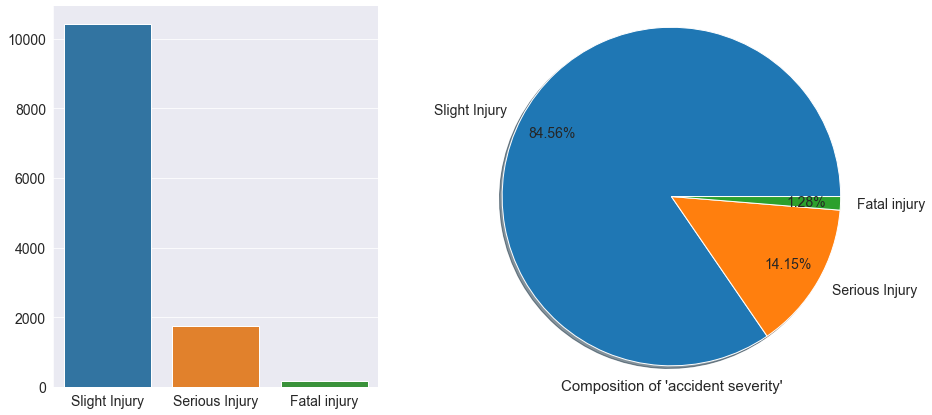

In [19]:
#Checking the target
plt.figure(figsize=(14,7))
#barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x=df["accident_severity"])
ax1.set_xlabel("")
ax1.set_ylabel("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(top=True, right = True)

#Pieplot
ax2 = plt.subplot(1,2,2)
plt.pie(df['accident_severity'].value_counts(),labels = list(df['accident_severity'].unique()),autopct='%1.2f%%',
pctdistance=0.8,shadow=True,radius = 1.3,textprops={'fontsize':14})
ax2.set_xlabel(" ")
plt.xlabel("Composition of 'accident severity'",fontsize=15,labelpad=20)
plt.subplots_adjust(wspace=0.4)
plt.show()

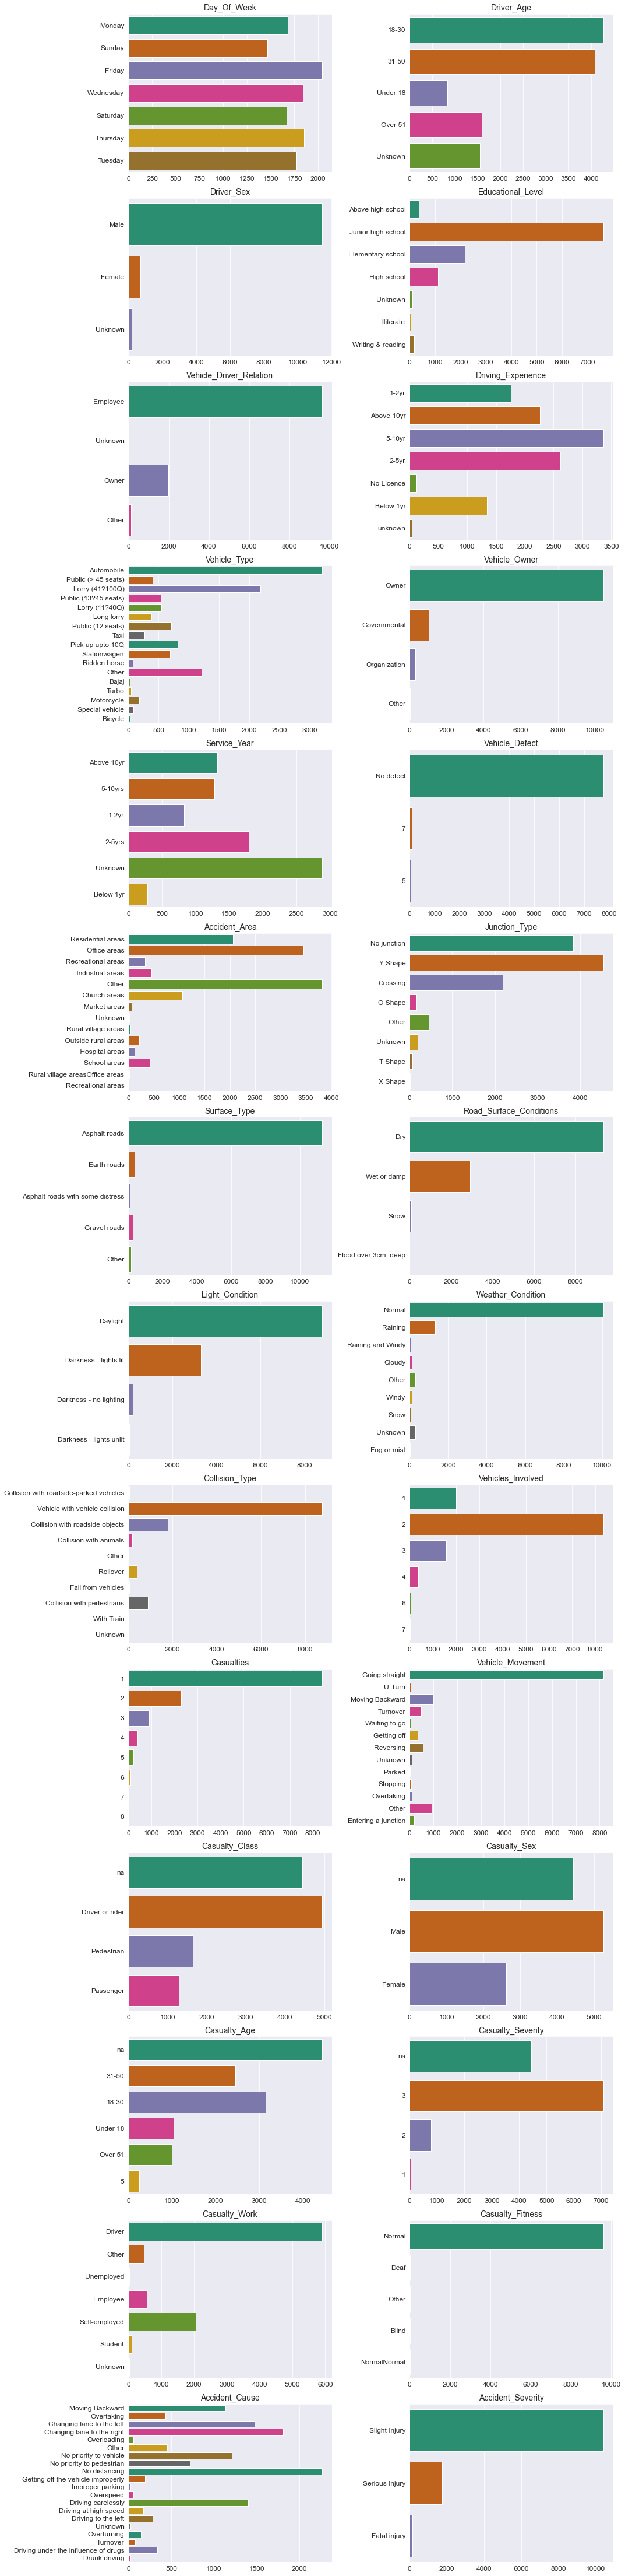

<Figure size 1080x5040 with 0 Axes>

In [20]:
plt.figure(figsize=(15,70))
plotnumber = 1

for col in df.drop(['hour', 'minute', 'lanes', 'road_allignment', 'pedestrian_movement'], axis=1):
    if plotnumber <= df.shape[1]:
        ax1 = plt.subplot(16,2,plotnumber)
        sns.countplot(data=df, y=col, palette='Dark2')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()
plt.figure(figsize=(15,70))
plotnumber = 1




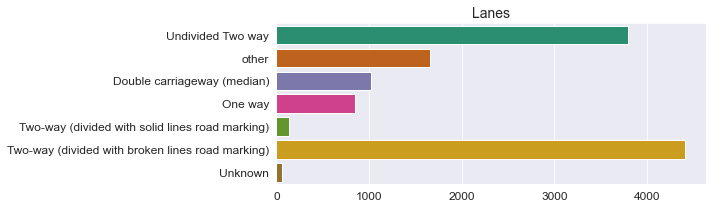

In [21]:
plt.figure(figsize=(10,3))
sns.countplot(data=df, y='lanes', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lanes', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

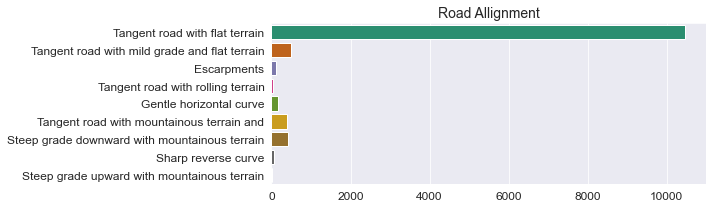

In [22]:
plt.figure(figsize=(10,3))
sns.countplot(data=df, y='road_allignment', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Road Allignment', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

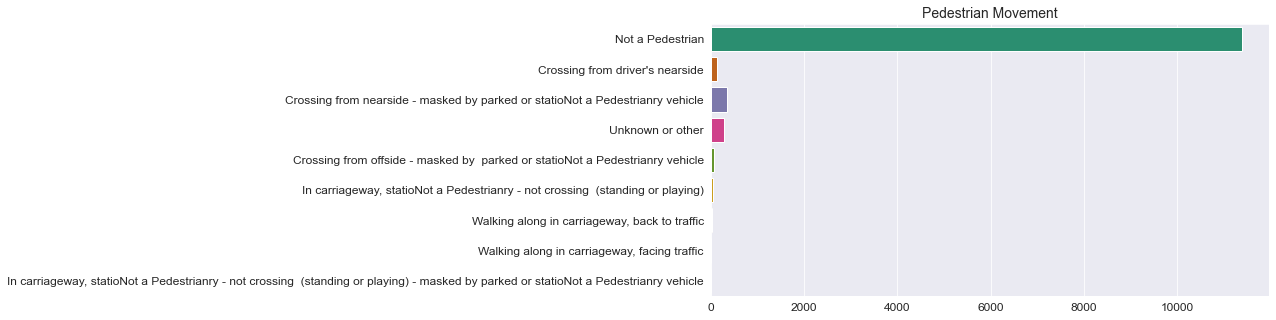

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='pedestrian_movement', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Pedestrian Movement', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

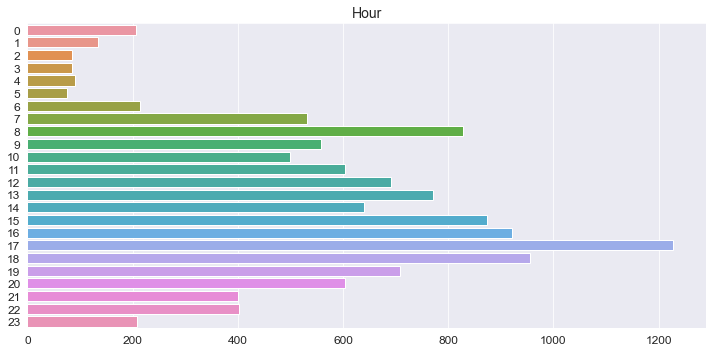

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='hour')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Hour', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

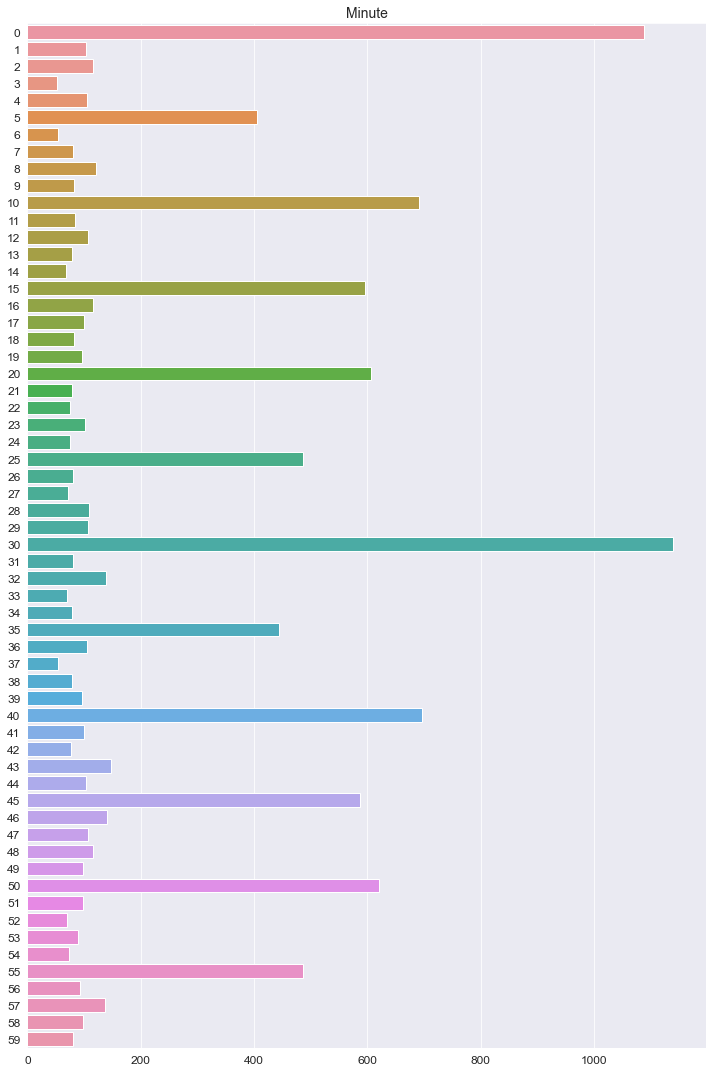

In [25]:
plt.figure(figsize=(10,15))
sns.countplot(data=df, y='minute')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Minute', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

Observations:
Accidents:
---> Most of the accident involved 2 vehicles and 2 casualties
--> Most of the accident held on 7AM - 8PM


Drivers:
---> Most of the drivers are male and age is 18-30 years
----> All the drivers went to upto junior high school 
---> Drivers experience is  5-10years

Casuality:

--> Most of the casualities are Male and severity 3

Most of the accident held in:

--> Y shape junction
--> Office areas
--> Daylight
--> Normal weather condition
--> Vehicle vehicle collision
--> Vehicle movement is staright
--> Two way road (divided with broken lines road marking)
--> Undivided two way road
--> Road allignment if tangent with flat terrain


Preprocessing

In [26]:
#Checking null values
df.isnull().sum()
# Check the NA values
100 * df.isnull().sum() / df.shape[0]

day_of_week                 0.000000
driver_age                  0.000000
driver_sex                  0.000000
educational_level           6.016564
vehicle_driver_relation     4.701202
driving_experience          6.731082
vehicle_type                7.713543
vehicle_owner               3.913608
service_year               31.893472
vehicle_defect             35.945112
accident_area               1.940565
lanes                       3.126015
road_allignment             1.152972
junction_type               7.202014
surface_type                1.396557
road_surface_conditions     0.000000
light_condition             0.000000
weather_condition           0.000000
collision_type              1.258525
vehicles_involved           0.000000
casualties                  0.000000
vehicle_movement            2.500812
casualty_class              0.000000
casualty_sex                0.000000
casualty_age                0.000000
casualty_severity           0.000000
casualty_work              25.966223
c

In [10]:
#Dropping the unwanted columns and high null value columns (this can cause imbalance while imputation)
df.drop(columns = ['vehicle_defect', 'vehicle_driver_relation', 'casualty_work', 'casualty_fitness','service_year','vehicle_owner'], inplace=True)

In [11]:
impute_cols = [x for x in df.isna().sum()[df.isna().sum() != 0].index.tolist()]
for i in impute_cols:
    mode = df[i].mode()[0]
    df[i].fillna(mode, inplace=True)

In [29]:
df.isna().sum()

day_of_week                0
driver_age                 0
driver_sex                 0
educational_level          0
driving_experience         0
vehicle_type               0
accident_area              0
lanes                      0
road_allignment            0
junction_type              0
surface_type               0
road_surface_conditions    0
light_condition            0
weather_condition          0
collision_type             0
vehicles_involved          0
casualties                 0
vehicle_movement           0
casualty_class             0
casualty_sex               0
casualty_age               0
casualty_severity          0
pedestrian_movement        0
accident_cause             0
accident_severity          0
hour                       0
minute                     0
dtype: int64

In [12]:
#we have ordinal and nominal columns 
#we can perform ordinal encoding for both because for ordinal columns we need to encode order wise, for nominal no need to encode order wise, so we can perform ordinal coding since this will assign the numbers to that like nominal encoder

def ordinal_encoder(df, feats): 
    for feat in feats:    
        feat_val = list(1+np.arange(df[feat].nunique()))
        feat_key = list(df[feat].sort_values().unique())
        feat_dict = dict(zip(feat_key, feat_val))
        df[feat] = df[feat].map(feat_dict)
    return df

df = ordinal_encoder(df, df.drop(['accident_severity'], axis=1).columns)
df.shape


(12316, 27)

In [31]:
df['accident_severity']

0         Slight Injury
1         Slight Injury
2        Serious Injury
3         Slight Injury
4         Slight Injury
              ...      
12311     Slight Injury
12312     Slight Injury
12313    Serious Injury
12314     Slight Injury
12315     Slight Injury
Name: accident_severity, Length: 12316, dtype: object

<AxesSubplot:>

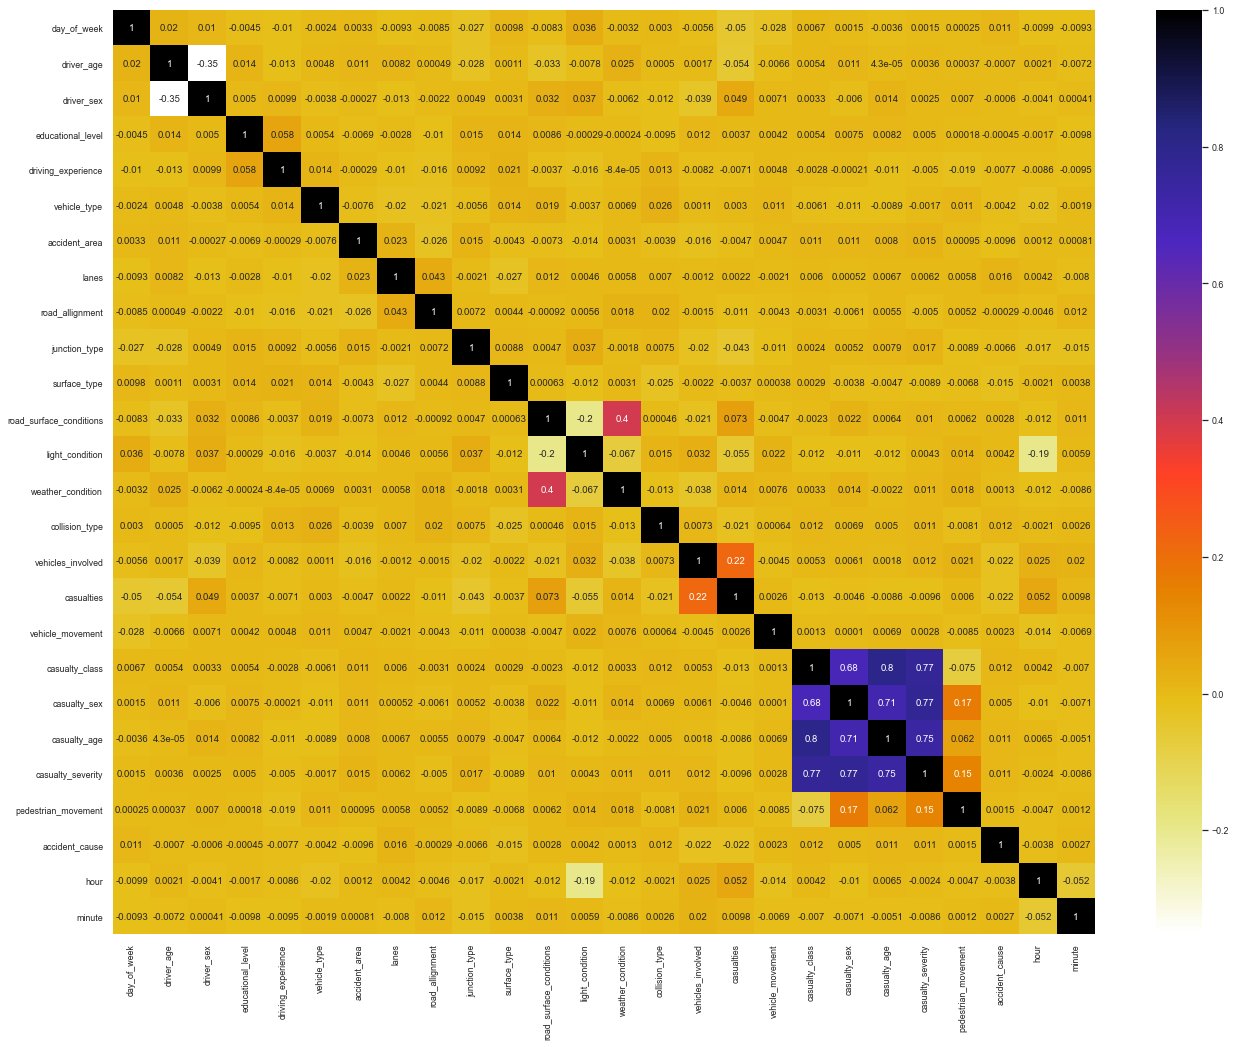

In [32]:
plt.figure(figsize=(22,17))
sns.set(font_scale=0.8)
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.CMRmap_r)

Train Test split

In [13]:
x = df.drop('accident_severity', axis = 1)
y = df['accident_severity']

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.3, random_state = 22)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8621, 26) (3695, 26) (8621,) (3695,)


In [14]:
# upsampling using smote

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", X_train.shape, y_train.shape)

Class= Slight Injury, n=7270 (84.33%)
Class= Serious Injury, n=1242 (14.41%)
Class= Fatal injury, n=109 (1.26%)
Class= Slight Injury, n=7270 (33.33%)
Class= Serious Injury, n=7270 (33.33%)
Class= Fatal injury, n=7270 (33.33%)
Upsampled data shape:  (21810, 26) (21810,)


Baseline models

In [15]:
y_test = ordinal_encoder(pd.DataFrame(y_test, columns = ['accident_severity']), pd.DataFrame(y_test, columns = ['accident_severity']).columns)['accident_severity']
y_train = ordinal_encoder(pd.DataFrame(y_train, columns = ['accident_severity']), pd.DataFrame(y_train, columns = ['accident_severity']).columns)['accident_severity']

In [16]:
import time

In [19]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb']= [accuracy_score(y_test, y_pred)]
#         scores['xgb']['roc_auc'] = roc_auc_score(y_test, y_pred)

    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf']= [accuracy_score(y_test, y_pred)]
#         scores['rf']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(rf)

    if 'extree' in kwargs.keys() and kwargs['extree']:
        extree = ExtraTreesClassifier()
        extree.fit(X_train, y_train)
        y_pred = extree.predict(X_test)
        scores['extree'] = [accuracy_score(y_test, y_pred)]
#         scores['extree']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(extree)
        
    return scores

In [20]:
modelling(X_train,y_train, X_test, y_test, xgb=True, rf=True, extree=True)

[20:42:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'xgb': [0.813531799729364],
 'rf': [0.8070365358592693],
 'extree': [0.8262516914749661]}

Feature selection for better accuracy

In [138]:
fs = SelectKBest(score_func=chi2, k=10)

"""fs = SelectKBest(score_func=chi2, k='20')
fs.fit(X_train,y_train)
feature_score = pd.DataFrame({"score":fs.scores_,"P_value":np.round(fs.pvalues_,3)},index = X_train.columns)   
feature_score.nlargest(n=17, columns='score') 
features_scores = feature_score[feature_score["score"]>70]
final =feature_score[feature_score["score"]>70]
final = features_scores.index.values.tolist()"""

'fs = SelectKBest(score_func=chi2, k=\'20\')\nfs.fit(X_train,y_train)\nfeature_score = pd.DataFrame({"score":fs.scores_,"P_value":np.round(fs.pvalues_,3)},index = X_train.columns)   \nfeature_score.nlargest(n=17, columns=\'score\') \nfeatures_scores = feature_score[feature_score["score"]>70]\nfinal =feature_score[feature_score["score"]>70]\nfinal = features_scores.index.values.tolist()'

In [139]:
X_train_new = fs.fit_transform(X_train, y_train)
X_test_new = fs.fit_transform(X_test,y_test)

#Extratreeclasiifier gives the better accuracy than all = 82.11

In [44]:
def modelling(X_train_new, y_train, X_test_new, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb']= [accuracy_score(y_test, y_pred)]
#         scores['xgb']['roc_auc'] = roc_auc_score(y_test, y_pred)

    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf']= [accuracy_score(y_test, y_pred)]
#         scores['rf']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(rf)

    if 'extree' in kwargs.keys() and kwargs['extree']:
        extree = ExtraTreesClassifier()
        extree.fit(X_train, y_train)
        y_pred = extree.predict(X_test)
        scores['extree'] = [accuracy_score(y_test, y_pred)]
#         scores['extree']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(extree)
        
    return scores

{'xgb': [0.813531799729364],
 'rf': [0.8070365358592693],
 'extree': [0.8262516914749661]}

In [45]:
modelling(X_train_new,y_train, X_test_new, y_test, xgb=True, rf=True, extree=True)

[20:55:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'xgb': [0.813531799729364],
 'rf': [0.8070365358592693],
 'extree': [0.8208389715832206]}

After several tuning also we not getting better accuracy than previous so we can gohead with that.

In [46]:
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)", "2 (pred)"],
                        y = ["0 (true)","1 (true)", "2 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    Accuracy  =  accuracy_score(y_test, y_hat)
    Precision =  precision_score(y_test, y_pred, average= 'weighted')
    Recall    =  recall_score(y_test, y_pred, average= 'weighted')
    F1_score  =  f1_score(y_test, y_pred, average= 'weighted')

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
 
     
    #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=1, print_grid=False, 
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,2,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = True, height = 800,width = 800,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        # margin = dict(b = 100)
                        )
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

In [55]:
extree = ExtraTreesClassifier()
extree.fit(X_train, y_train)
y_pred = extree.predict(X_test)

In [48]:
extree.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [49]:
model_performance(extree,y_test, y_pred)

Hyperparameter tuning 

In [50]:
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

# A parameter grid for XGBoost
params = {
    'n_estimators': range(100, 500, 100),
    'ccp_alpha': [0.0, 0.1],
    'criterion': ['gini'],
    'max_depth': [5,11],
    'min_samples_split': [2,3],
}

extree_estimator = ExtraTreesClassifier()

gsearch = GridSearchCV(
    estimator= extree_estimator,
    param_grid= params,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=gkf,
    verbose=3,
)

extree_model = gsearch.fit(X=X_train_new, y=y_train)
(gsearch.best_params_, gsearch.best_score_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


({'ccp_alpha': 0.0,
  'criterion': 'gini',
  'max_depth': 11,
  'min_samples_split': 2,
  'n_estimators': 300},
 0.8547276274087281)

In [63]:
gkf2 = KFold(n_splits=3, shuffle=True, random_state=101).split(X=X_train, y=y_train)

params2 = {
    'n_estimators': range(400, 800, 100),
    'max_depth': [11,15],
    'min_samples_split': [2,3],
    'class_weight': ['balanced', None],

}

extree2 = ExtraTreesClassifier(ccp_alpha = 0.0,
                                criterion = 'gini',
                                max_depth = 15,
                                min_samples_split = 3,
                                n_estimators = 400)

gsearch2 = GridSearchCV(
    estimator= extree2,
    param_grid= params2,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=gkf2,
    verbose=3,
)

extree_model2 = gsearch2.fit(X=X_train_new, y=y_train)

  
(gsearch2.best_params_, gsearch2.best_score_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


({'class_weight': None,
  'max_depth': 15,
  'min_samples_split': 2,
  'n_estimators': 400},
 0.9166411666044058)

In [140]:
model = ExtraTreesClassifier(ccp_alpha = 0.0,
                                criterion = 'gini',
                                min_samples_split = 2,
                                class_weight = 'balanced',
                                max_depth = 15,
                                n_estimators = 400)

model.fit(X_train_new, y_train)
y_pred_tuned = model.predict(X_test_new)

In [141]:
import joblib
joblib.dump(model, 'Extratreeclassifier_model.joblib')

['Extratreeclassifier_model.joblib']